## Definitions

In [9]:
%matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adam, SGD
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/My Drive") 

Mounted at /content/gdrive


## Load and format data

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f4fc1885c18>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


Number of classes: 10
Example of handwritten digit with correlated noise: 



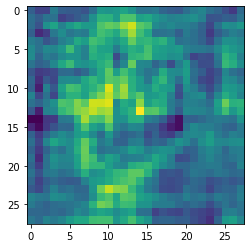

Class: 0

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [10]:
data = np.load('MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 1
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and standarize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

## Training

In [11]:
model_name='CNN'

pweight='./weights/weights_' + model_name  + '.hdf5'

if not os.path.exists('./weights'):
  os.mkdir('./weights')


b_size = 150 # batch size
val_split = .35 # percentage of samples used for validation (e.g. 0.5)
ep = 15 # number of epochs

In [12]:
from keras.callbacks import Callback

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                589888    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

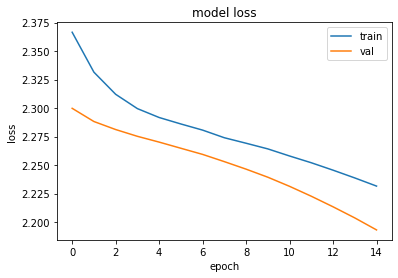

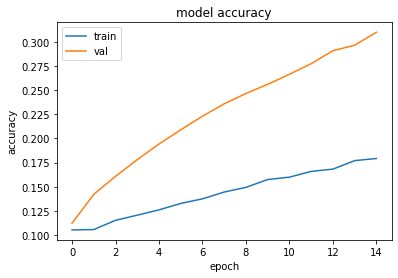

In [13]:
input_shape = x_train.shape[1:4] #(28,28,1)
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) 
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_cls, activation='softmax')) 

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(), 
              metrics=['accuracy'])

model.summary()

checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)
es = EarlyStopping(monitor="val_loss",min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpointer,es] 

history=model.fit(x_train, y_train,
                        epochs=ep,
                        batch_size=b_size,
                        verbose=1,
                        shuffle=True,
                        validation_split = val_split,
                        callbacks=callbacks_list)

print('CNN weights saved in ' + pweight)

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [14]:
print("Training accuracy after ",ep," epochs")
print(history.history['accuracy'][-1])

Training accuracy after  15  epochs
0.17917948961257935


## Make predictions in test set

In [15]:
from keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test']

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)

print('Shape of x_train: '+str(x_test.shape)+'\n')


model_name='CNN' 
pweight='./weights/weights_' + model_name  + '.hdf5'

model = load_model(pweight)
y_pred = model.predict_classes(x_test)

Acc_pred = sum(y_pred == y_test)/len(y_test)

print('Accuracy in test set is: '+str(Acc_pred))


Number of classes: 10
Shape of x_train: (10000, 28, 28, 1)

Accuracy in test set is: 0.3185
